# Giovanni's playground

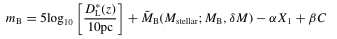  

Apparent Magnitude Function (Eq. 9, Alsing 2018)

# Data

## Importing modules and data from the JLA

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt 
import jax 
import jax.numpy as jnp
import numpyro 
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median
import astropy.units as u
import astropy.constants as con
import matplotlib.patches as mpatches

import mag_fns_jax as mag
import os 
import dill
from typing import Any
from getdist import plots, MCSamples
import getdist

In [2]:
# assign data from each column to specified parameters (z,C,X1)
data = pd.read_csv("data/jla_lcparams.txt", sep=" ", header=0)
covariance = np.load("data/covariance.npz")["arr_0"]
ndata = len(data)
columns = ["mb", "zcmb", "3rdvar", "x1", "color"]
data_filtered = data[columns]
data_filtered.columns = ["mb", "redshift", "M_stellar", "X_1", "C"]
mb=data_filtered["mb"]
z=data_filtered["redshift"]
x1=data_filtered["X_1"]
C=data_filtered["C"]
mstellar=data_filtered["M_stellar"]*10**10

In [3]:
inputs = data_filtered[["redshift", "M_stellar", "X_1", "C"]].values
#input_data = pd.DataFrame(inputs, columns = ['redshift', 'Mstellar', 'X1', 'C'])

In [4]:
# convert to arrays
mb_arr=mb.to_numpy()
z_arr = z.to_numpy()
x1_arr = x1.to_numpy()
C_arr = C.to_numpy()
mstell_arr = mstellar.to_numpy()

# Theory
We need some code here to compute the forward model (and we should be able to show an approximate theory and the data before proceeding with the next section). The cosmological and nuisance parameters are:

$$
\theta = (\Omega_{m},\,w_{0},\,M_{B},\,\delta M_{B},\, \alpha,\, \beta)
$$

Therefore, we need a function which takes as input these parameters and outputs the apparent magnitude (the theory).

## Assigning values to the parameters based off of previous literature analysis. 

In [5]:
# set the parameters to accepted values
Om_m=0.315
w0=-1
alpha=0.1257
beta=2.644
Mb= -19.05
deltM= -0.061
cosmo_params=[Om_m,w0]
nuisance=[alpha,beta,Mb,deltM]

## Implementing Eq. 9

In [6]:
# Implement the Heaviside function
def Heavi(mstellar):
    return jnp.where(mstellar < 10**10, 0, 1)

# Define the M~_B parameter
def absM(mstellar,Mb,deltM):
    absMag=Mb+(deltM*Heavi(mstellar))
    return absMag

# integrand should depend on Om_m,z,w0
def integrand(z,Om_m=0.315,w0=-1):
    den = Om_m*((1+z)**3)+(1-Om_m)*(1+z)**(3*(w0+1))
    integ=1/(jnp.sqrt(den))
    return integ

# Implement the Luminosity Distance equation (Equation 10 Alsing et al. 2018)
# "70" in denom of 'factor' is the Hubble constant
def D_L(z,Om_m=0.315,w0=-1, num=500):
    factor=(((1+z)*(con.c.value/1000))/70)
    dz = jnp.linspace(0, z, num=num)
    y = integrand(dz,Om_m,w0)
    integral = jnp.trapezoid(y,dz)
    return factor*integral

# This is Equation 9 in Alsing et al. 2018
def m_b(z,Om_m,w0,alpha,beta,mstellar,X1,C,Mb,deltM):
    mB_final= 5*jnp.log10(((D_L(z)*10**6)/10)) + absM(mstellar,Mb,deltM)-(alpha*X1)+(beta*C)
    return mB_final

def compute_mags(inputs,cosmo_params=cosmo_params,nuisance=nuisance):
    Om_m,w0 = cosmo_params
    alpha, beta, Mb, deltM = nuisance 
    redshift, mstellar, x1, C = inputs
    return m_b(redshift,Om_m,w0,alpha,beta,mstellar,x1,C,Mb,deltM)

## Calculating the values of mb using the input parameter values

In [7]:
# Loop to calculate magnitudes of all 740 Supernovae
df = pd.DataFrame(columns=['magnitude'])
for i in range(0, len(z_arr)):
    mB_final= 5*jnp.log10(((D_L(z_arr[i])*10**6)/10)) + absM(mstell_arr[i],Mb,deltM)-(alpha*x1_arr[i])+(beta*C_arr[i])
    new_row = {'magnitude': mB_final}
    df.loc[len(df)] = new_row
print(df)

     magnitude
0    22.962244
1    23.340532
2    22.939882
3    22.233168
4    23.753511
..         ...
735  16.549263
736   16.04096
737  15.745914
738  16.017859
739  15.646855

[740 rows x 1 columns]


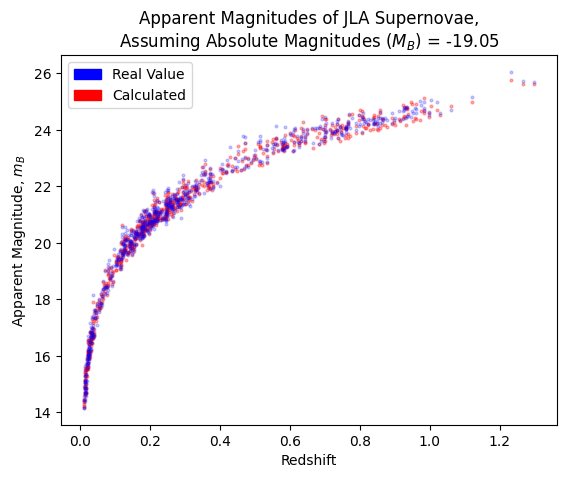

In [8]:
# Plot the JLA mb with the calculated mb
# theoretical values from the code
N = 740
x = z_arr
y = df
plt.plot(x, y, '.',color = 'red', ms=4, alpha=0.3)
# real values from the JLA
x = z_arr
y = mb_arr
plt.plot(x, y, '.',color = 'blue', ms=4, alpha=0.2)
plt.title("Apparent Magnitudes of JLA Supernovae,\nAssuming Absolute Magnitudes ($M_B$) = -19.05")
plt.xlabel("Redshift")
plt.ylabel("Apparent Magnitude, $m_B$")

plt.plot(z,mb,'.',ms=4,alpha=0.00001,label='supernovae')

Source_1 = mpatches.Patch(color='blue', label='Real Value')
Source_2 = mpatches.Patch(color='Red', label='Calculated')
plt.legend(handles=[Source_1,Source_2])
plt.show()

# Inference
Use the following as the priors for the six parameters:

- $\Omega_{m}\sim U[0.001, 0.6]$
- $w_{0}\sim U[-1.5, 0.0]$
- $M_{B}\sim \mathcal{N}(-19.0, 1.0)$  
- $\delta M_{B}\sim \mathcal{N}(-0.05, 1.0)$
- $\alpha \sim \mathcal{N}(0.125, 1.0)$
- $\beta \sim \mathcal{N}(2.6, 1.0)$

# Creating the likelihood function
Here, we want to use MCMC to do this. We are using No U-Turn Sampler

In [9]:
# turn the df datafram to floats
calc_mags = df.astype(np.float32)

In [10]:
# sort the redshifts numerically
idx = np.argsort(data_filtered["redshift"].values)
z_sorted = data_filtered["redshift"].values[idx]
mb_sorted = calc_mags

In [11]:
def compute_theory(inputs):
        zs, Mstellar, X1, C = inputs
        return m_b(zs,Mstellar, X1, C, Om_m,w0, alpha,beta,deltM,Mstellar)

In [12]:
def model(data,covariance,inputs):
    # define the priors
    Om_m=numpyro.sample("Om_m",dist.Uniform(0.001,0.6))
    w0=numpyro.sample("w0",dist.Uniform(-1.5,0.0))
    M_abs=numpyro.sample("M_abs",dist.Normal(-19.00,1.00))
    delt_M=numpyro.sample("delt_M",dist.Normal(-0.05,1.0))
    alpha=numpyro.sample("alpha",dist.Normal(0.125,1.0))
    beta=numpyro.sample("beta",dist.Normal(2.6,1.0))

    # Repack the parameters
    cosmo_params = [Om_m, w0]
    nuisance_params = [M_abs, delt_M, alpha, beta]

    # use compute_theory instead of m_b
    def theoretical(inputs):
        return mag.compute_theory(inputs, cosmo_params=cosmo_params, nuisance_params=nuisance_params)
    theory = jax.lax.map(theoretical, inputs)

    # the sampling distribution
    sampling_distribution = dist.MultivariateNormal(theory, covariance_matrix=covariance)
    numpyro.sample("obs", sampling_distribution, obs=data)

In [13]:
# set the step size and the tree depth
step_size = 0.1
tree_depth=5

In [14]:
nuts = NUTS(model, step_size = step_size, init_strategy=init_to_median,dense_mass=True, max_tree_depth=tree_depth)

In [15]:
mcmc_NUTS= MCMC(nuts,
                num_warmup=500,
                num_samples=20000,
                num_chains=2,
                chain_method="vectorized",
                progress_bar=True)

In [16]:
mcmc_NUTS.run(jax.random.PRNGKey(253), data_filtered["mb"].values, covariance, inputs)

sample: 100%|█████████████████████████████████████████████████| 20500/20500 [31:28<00:00, 10.86it/s]


# Posterior Plot and Analysis
We need some code here to plot the results. There is a nice tutorial of how to generate beautiful plots [here](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

In [17]:
# Save results
def dill_save(file: Any, folder: str, fname: str) -> None:
    """Stores a file, for example, MCMC samples.
    Args:
        file (Any): the file we want to store.
        folder (str): folder where we want to store the file
        fname (str): the name of the file.
    """
    os.makedirs(folder, exist_ok=True)
    # use compressed format to store data
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "wb") as dummy:
        dill.dump(file, dummy)


def dill_load(folder: str, fname: str) -> Any:
    """Reads a file from a folder.
    Args:
        folder(str): the name of the folder.
        file (str): the name of the file.
    Returns:
        Any: the stored file
    """
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "rb") as dummy:
        file = dill.load(dummy)
    return file

In [18]:
# Visualize the results in a table 
import arviz as az

inf_data = az.from_numpyro(mcmc_NUTS)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M_abs,-19.041,0.025,-19.086,-18.994,0.000,0.000,19263.0,24048.0,1.0
Om_m,0.219,0.113,0.002,0.394,0.002,0.001,3729.0,4021.0,1.0
alpha,0.125,0.006,0.114,0.136,0.000,0.000,45975.0,28313.0,1.0
beta,2.617,0.067,2.494,2.745,0.000,0.000,33095.0,29031.0,1.0
delt_M,-0.052,0.021,-0.091,-0.011,0.000,0.000,30401.0,26317.0,1.0
w0,-0.807,0.203,-1.196,-0.500,0.003,0.003,3787.0,3021.0,1.0


In [19]:
samples = mcmc_NUTS.get_samples()
columns = ['Om_m', 'w0', 'M_abs', 'delt_M', 'alpha', 'beta']
mcmc_samples = np.vstack([samples[c] for c in columns]).T

In [20]:
color1 = "#50C878" 
settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
ndim = len(columns)
names = ["x%s"%i for i in range(ndim)]
labels = [
    r"\Omega_{m}",
    r"w_{0}",
    r"M",
    r"\delta M",
    r"\alpha",
    r"\beta"]
getdist_samples = MCSamples(samples=mcmc_samples,names = names, labels = labels, ranges={'x0':(0.0, None)}, label = 'JLA (NUTS)', settings = settings)

Removed no burn in


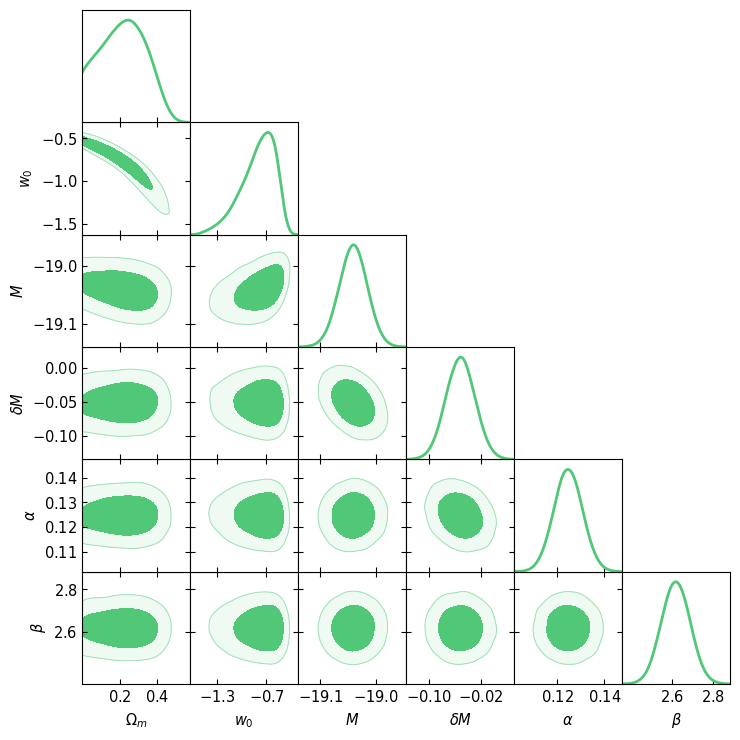

In [21]:
# Create a triangle plot of the likelihood function results
G = plots.getSubplotPlotter(subplot_size=1.25)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.5
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  
G.settings.legend_fontsize = 15
getdist_samples.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot([getdist_samples],
    filled=[True],
    contour_colors=[color1],
    contour_lws=[2],
    contour_ls=["-"],
)
# plt.savefig('triangle_plot_jla_nuts.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

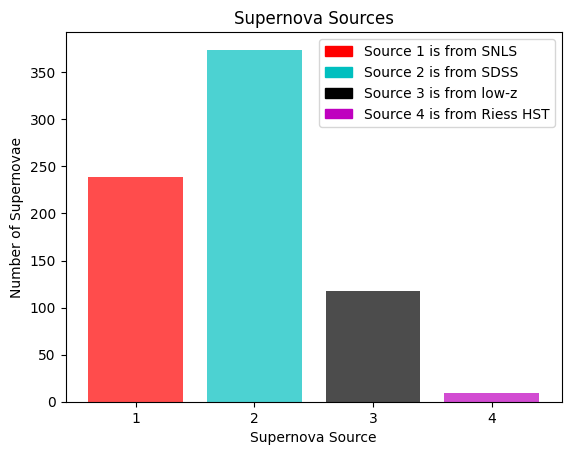

In [22]:
# Create a histogram to visualize which survey SNIa data comes from
data = pd.read_csv("data/jla_lcparams.txt", sep=" ", header=0)
snls = data[data['set'] == 1]['set']
sdss = data[data['set'] == 2]['set']
lowz = data[data['set'] == 3]['set']
riess = data[data['set'] == 4]['set']
color = ['red', 'c', 'k', 'm'], 0.7

x = [1,2,3,4]
y = [len(snls),len(sdss),len(lowz),len(riess)]
plt.bar(x, y, color=color,)
plt.xticks(x)
plt.xlabel("Supernova Source")
plt.ylabel("Number of Supernovae")
plt.title(f"Supernova Sources")
import matplotlib.patches as mpatches
Source_1 = mpatches.Patch(color='red', label='Source 1 is from SNLS')
Source_2 = mpatches.Patch(color='c', label='Source 2 is from SDSS')
Source_3 = mpatches.Patch(color='k', label='Source 3 is from low-z')
Source_4 = mpatches.Patch(color='m', label='Source 4 is from Riess HST')
plt.legend(handles=[Source_1,Source_2,Source_3,Source_4])